The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.3


# Gaussian Process Priors

Understanding Gaussian processes (GPs) is important for reasoning about model construction and generalization, and for achieving state-of-the-art performance in a variety of applications, including active learning, and hyperparameter tuning in deep learning. GPs are everywhere, and it is in our interests to know what they are and how we can use them.

In this section, we introduce Gaussian process _priors_ over functions. In the next notebook, we show how to use these priors to do _posterior inference_ and make predictions. The next section can be viewed as "GPs in a nutshell", quickly giving what you need to apply Gaussian processes in practice.


In [1]:
import numpy as np
from scipy.spatial import distance_matrix
from d2l import torch as d2l

d2l.set_figsize()

## Definition

A Gaussian process is defined as _a collection of random variables, any finite number of which have a joint Gaussian distribution_. If a function $f(x)$ is a Gaussian process, with _mean function_ $m(x)$ and _covariance function_ or _kernel_ $k(x,x')$, $f(x) \sim \mathcal{GP}(m, k)$, then any collection of function values queried at any collection of input points $x$ (times, spatial locations, image pixels, etc.), has a joint multivariate Gaussian distribution with mean vector $\mu$ and covariance matrix $K$: $f(x_1),\dots,f(x_n) \sim \mathcal{N}(\mu, K)$, where $\mu_i = E[f(x_i)] = m(x_i)$ and $K_{ij} = \textrm{Cov}(f(x_i),f(x_j)) = k(x_i,x_j)$.

This definition may seem abstract and inaccessible, but Gaussian processes are in fact very simple objects. Any function

$$f(x) = w^{\top} \phi(x) = \langle w, \phi(x) \rangle,$$ :eqlabel:`eq_gp-function`

with $w$ drawn from a Gaussian (normal) distribution, and $\phi$ being any vector of basis functions, for example $\phi(x) = (1, x, x^2, ..., x^d)^{\top}$,
is a Gaussian process. Moreover, any Gaussian process f(x) can be expressed in the form of equation :eqref:`eq_gp-function`. Let's consider a few concrete examples, to begin getting acquainted with Gaussian processes, after which we can appreciate how simple and useful they really are.

## A Simple Gaussian Process

Suppose $f(x) = w_0 + w_1 x$, and $w_0, w_1 \sim \mathcal{N}(0,1)$, with $w_0, w_1, x$ all in one dimension. We can equivalently write this function as the inner product $f(x) = (w_0, w_1)(1, x)^{\top}$. In :eqref:`eq_gp-function` above, $w = (w_0, w_1)^{\top}$ and $\phi(x) = (1,x)^{\top}$.

For any $x$, $f(x)$ is a sum of two Gaussian random variables. Since Gaussians are closed under addition, $f(x)$ is also a Gaussian random variable for any $x$. In fact, we can compute for any particular $x$ that $f(x)$ is $\mathcal{N}(0,1+x^2)$. Similarly, the joint distribution for any collection of function values, $(f(x_1),\dots,f(x_n))$, for any collection of inputs $x_1,\dots,x_n$, is a multivariate Gaussian distribution. Therefore $f(x)$ is a Gaussian process.

In short, $f(x)$ is a _random function_, or a _distribution over functions_. We can gain some insights into this distribution by repeatedly sampling values for $w_0, w_1$, and visualizing the corresponding functions $f(x)$, which are straight lines with slopes and different intercepts, as follows:


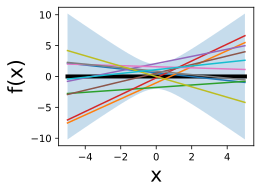

In [2]:
def lin_func(x, n_sample):
    preds = np.zeros((n_sample, x.shape[0]))
    for ii in range(n_sample):
        w = np.random.normal(0, 1, 2)
        y = w[0] + w[1] * x
        preds[ii, :] = y
    return preds

x_points = np.linspace(-5, 5, 50)
outs = lin_func(x_points, 10)
lw_bd = -2 * np.sqrt((1 + x_points ** 2))
up_bd = 2 * np.sqrt((1 + x_points ** 2))

d2l.plt.fill_between(x_points, lw_bd, up_bd, alpha=0.25)
d2l.plt.plot(x_points, np.zeros(len(x_points)), linewidth=4, color='black')
d2l.plt.plot(x_points, outs.T)
d2l.plt.xlabel("x", fontsize=20)
d2l.plt.ylabel("f(x)", fontsize=20)
d2l.plt.show()

If $w_0$ and $w_1$ are instead drawn from $\mathcal{N}(0,\alpha^2)$, how do you imagine varying $\alpha$ affects the distribution over functions?

## From Weight Space to Function Space

In the plot above, we saw how a distribution over parameters in a model induces a distribution over functions. While we often have ideas about the functions we want to model --- whether they're smooth, periodic, quickly varying, etc. --- it is relatively tedious to reason about the parameters, which are largely uninterpretable. Fortunately, Gaussian processes provide an easy mechanism to reason _directly_ about functions. Since a Gaussian distribution is entirely defined by its first two moments, its mean and covariance matrix, a Gaussian process by extension is defined by its mean function and covariance function.

In the above example, the mean function

$$m(x) = E[f(x)] = E[w_0 + w_1x] = E[w_0] + E[w_1]x = 0+0 = 0.$$

Similarly, the covariance function is

$$k(x,x') = \textrm{Cov}(f(x),f(x')) = E[f(x)f(x')]-E[f(x)]E[f(x')] = E[w_0^2 + w_0w_1x' + w_1w_0x + w_1^2xx'] = 1 + xx'.$$

Our distribution over functions can now be directly specified and sampled from, without needing to sample from the distribution over parameters. For example, to draw from $f(x)$, we can simply form our multivariate Gaussian distribution associated with any collection of $x$ we want to query, and sample from it directly. We will begin to see just how advantageous this formulation will be.

First, we note that essentially the same derivation for the simple straight line model above can be applied to find the mean and covariance function for _any_ model of the form $f(x) = w^{\top} \phi(x)$, with $w \sim \mathcal{N}(u,S)$. In this case, the mean function $m(x) = u^{\top}\phi(x)$, and the covariance function $k(x,x') = \phi(x)^{\top}S\phi(x')$. Since $\phi(x)$ can represent a vector of any non-linear basis functions, we are considering a very general model class, including models with an even an _infinite_ number of parameters.

## The Radial Basis Function (RBF) Kernel

The _radial basis function_ (RBF) kernel is the most popular covariance function for Gaussian processes, and kernel machines in general.
This kernel has the form $k_{\textrm{RBF}}(x,x') = a^2\exp\left(-\frac{1}{2\ell^2}||x-x'||^2\right)$, where $a$ is an amplitude parameter, and $\ell$ is a _lengthscale_ hyperparameter.

Let's derive this kernel starting from weight space. Consider the function

$$f(x) = \sum_{i=1}^J w_i \phi_i(x), w_i  \sim \mathcal{N}\left(0,\frac{\sigma^2}{J}\right), \phi_i(x) = \exp\left(-\frac{(x-c_i)^2}{2\ell^2 }\right).$$

$f(x)$ is a sum of radial basis functions, with width $\ell$, centred at the points $c_i$, as shown in the following figure.


We can recognize $f(x)$ as having the form $w^{\top} \phi(x)$, where $w = (w_1,\dots,w_J)^{\top}$ and $\phi(x)$ is a vector containing each of the radial basis functions. The covariance function of this Gaussian process is then

$$k(x,x') = \frac{\sigma^2}{J} \sum_{i=1}^{J} \phi_i(x)\phi_i(x').$$

Now let's consider what happens as we take the number of parameters (and basis functions) to infinity. Let $c_J = \log J$, $c_1 = -\log J$, and $c_{i+1}-c_{i} = \Delta c = 2\frac{\log J}{J}$, and $J \to \infty$. The covariance function becomes the Riemann sum:

$$k(x,x') = \lim_{J \to \infty} \frac{\sigma^2}{J} \sum_{i=1}^{J} \phi_i(x)\phi_i(x') = \int_{c_0}^{c_\infty} \phi_c(x)\phi_c(x') dc.$$

By setting $c_0 = -\infty$ and $c_\infty = \infty$, we spread the infinitely many basis functions across the whole real line, each
a distance $\Delta c \to 0$ apart:

$$k(x,x') = \int_{-\infty}^{\infty} \exp(-\frac{(x-c)^2}{2\ell^2}) \exp(-\frac{(x'-c)^2}{2\ell^2 }) dc = \sqrt{\pi}\ell \sigma^2 \exp(-\frac{(x-x')^2}{2(\sqrt{2} \ell)^2}) \propto k_{\textrm{RBF}}(x,x').$$

It is worth taking a moment to absorb what we have done here. By moving into the function space representation, we have derived how to represent a model with an _infinite_ number of parameters, using a finite amount of computation. A Gaussian process with an RBF kernel is a _universal approximator_, capable of representing any continuous function to arbitrary precision. We can intuitively see why from the above derivation. We can collapse each radial basis function to a point mass taking $\ell \to 0$, and give each point mass any height we wish.

So a Gaussian process with an RBF kernel is a model with an infinite number of parameters and much more flexibility than any finite neural network. Perhaps all the fuss about _overparametrized_ neural networks is misplaced. As we will see, GPs with RBF kernels do not overfit, and in fact provide especially compelling generalization performance on small datasets. Moreover, the examples in :cite:`zhang2021understanding`, such as the ability to fit images with random labels perfectly, but still generalize well on structured problems, (can be perfectly reproduced using Gaussian processes) :cite:`wilson2020bayesian`. Neural networks are not as distinct as we make them out to be.

We can build further intuition about Gaussian processes with RBF kernels, and hyperparameters such as _length-scale_, by sampling directly from the distribution over functions. As before, this involves a simple procedure:

1. Choose the input $x$ points we want to query the GP: $x_1,\dots,x_n$.
2. Evaluate $m(x_i)$, $i = 1,\dots,n$, and $k(x_i,x_j)$ for $i,j = 1,\dots,n$ to respectively form the mean vector and covariance matrix $\mu$ and $K$, where $(f(x_1),\dots,f(x_n)) \sim \mathcal{N}(\mu, K)$.
3. Sample from this multivariate Gaussian distribution to obtain the sample function values.
4. Sample more times to visualize more sample functions queried at those points.

We illustrate this process in the figure below.


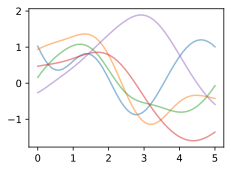

In [3]:
def rbfkernel(x1, x2, ls=4.):  #@save
    dist = distance_matrix(np.expand_dims(x1, 1), np.expand_dims(x2, 1))
    return np.exp(-(1. / ls / 2) * (dist ** 2))

x_points = np.linspace(0, 5, 50)
meanvec = np.zeros(len(x_points))
covmat = rbfkernel(x_points,x_points, 1)

prior_samples= np.random.multivariate_normal(meanvec, covmat, size=5);
d2l.plt.plot(x_points, prior_samples.T, alpha=0.5)
d2l.plt.show()

## The Neural Network Kernel

Research on Gaussian processes in machine learning was triggered by research on neural networks. Radford Neal was pursuing ever larger Bayesian neural networks, ultimately showing in 1994 (later published in 1996, as it was one of the most infamous NeurIPS rejections) that such networks with an infinite number of hidden units become Gaussian processes with particular kernel functions :cite:`neal1996bayesian`. Interest in this derivation has re-surfaced, with ideas like the neural tangent kernel being used to investigate the generalization properties of neural networks :cite:`matthews2018gaussian` :cite:`novak2018bayesian`. We can derive the neural network kernel as follows.

Consider a neural network function $f(x)$ with one hidden layer:

$$f(x) = b + \sum_{i=1}^{J} v_i h(x; u_i).$$

$b$ is a bias, $v_i$ are the hidden to output weights, $h$ is any bounded hidden unit transfer function, $u_i$ are the input to hidden weights, and $J$ is the number of hidden units. Let $b$ and $v_i$ be independent with zero mean and variances $\sigma_b^2$ and $\sigma_v^2/J$, respectively, and let the $u_i$ have independent identical distributions. We can then use the central limit theorem to show that any collection of function values $f(x_1),\dots,f(x_n)$ has a joint multivariate Gaussian distribution.

The mean and covariance function of the corresponding Gaussian process are:

$$m(x) = E[f(x)] = 0$$

$$k(x,x') = \textrm{cov}[f(x),f(x')] = E[f(x)f(x')] = \sigma_b^2 + \frac{1}{J} \sum_{i=1}^{J} \sigma_v^2 E[h_i(x; u_i)h_i(x'; u_i)]$$

In some cases, we can essentially evaluate this covariance function in closed form. Let $h(x; u) = \textrm{erf}(u_0 + \sum_{j=1}^{P} u_j x_j)$, where $\textrm{erf}(z) = \frac{2}{\sqrt{\pi}} \int_{0}^{z} e^{-t^2} dt$, and $u \sim \mathcal{N}(0,\Sigma)$. Then $k(x,x') = \frac{2}{\pi} \textrm{sin}(\frac{2 \tilde{x}^{\top} \Sigma \tilde{x}'}{\sqrt{(1 + 2 \tilde{x}^{\top} \Sigma \tilde{x})(1 + 2 \tilde{x}'^{\top} \Sigma \tilde{x}')}})$.

The RBF kernel is _stationary_, meaning that it is _translation invariant_, and therefore can be written as a function of $\tau = x-x'$. Intuitively, stationarity means that the high-level properties of the function, such as rate of variation, do not change as we move in input space. The neural network kernel, however, is _non-stationary_. Below, we show sample functions from a Gaussian process with this kernel. We can see that the function looks qualitatively different near the origin.

## Summary


The first step in performing Bayesian inference involves specifying a prior. Gaussian processes can be used to specify a whole prior over functions. Starting from a traditional "weight space" view of modelling, we can induce a prior over functions by starting with the functional form of a model, and introducing a distribution over its parameters. We can alternatively specify a prior distribution directly in function space, with properties controlled by a kernel. The function-space approach has many advantages. We can build models that actually correspond to an infinite number of parameters, but use a finite amount of computation! Moreover, while these models have a great amount of flexibility, they also make strong assumptions about what types of functions are a priori likely, leading to relatively good generalization on small datasets.

The assumptions of models in function space are intuitively controlled by kernels, which often encode higher level properties of functions, such as smoothness and periodicity. Many kernels are stationary, meaning that they are translation invariant. Functions drawn from a Gaussian process with a stationary kernel have roughly the same high-level properties (such as rate of variation) regardless of where we look in the input space.

Gaussian processes are a relatively general model class, containing many examples of models we are already familiar with, including polynomials, Fourier series, and so on, as long as we have a Gaussian prior over the parameters. They also include neural networks with an infinite number of parameters, even without Gaussian distributions over the parameters. This connection, discovered by Radford Neal, triggered machine learning researchers to move away from neural networks, and towards Gaussian processes.


## Exercises

1. Draw sample prior functions from a GP with an Ornstein-Uhlenbeck (OU) kernel, $k_{\textrm{OU}}(x,x') = \exp\left(-\frac{1}{2\ell}||x - x'|\right)$. If you fix the lengthscale $\ell$ to be the same, how do these functions look different than sample functions from a GP with an RBF kernel?

2. How does changing the _amplitude_ $a^2$ of the RBF kernel affect the distribution over functions?

3. Suppose we form $u(x) = f(x) + 2g(x)$, where $f(x) \sim \mathcal{GP}(m_1,k_1)$ and $g(x) \sim \mathcal{GP}(m_2,k_2)$. Is $u(x)$ a Gaussian process, and if so, what is its mean and covariance function?

4. Suppose we form $g(x) = a(x)f(x)$, where $f(x) \sim \mathcal{GP}(0,k)$ and $a(x) = x^2$. Is $g(x)$ a Gaussian process, and if so, what is its mean and covariance function? What is the effect of $a(x)$? What do sample functions drawn from $g(x)$ look like?

5. Suppose we form $u(x) = f(x)g(x)$, where $f(x) \sim \mathcal{GP}(m_1,k_1)$ and $g(x) \sim \mathcal{GP}(m_2,k_2)$. Is $u(x)$ a Gaussian process, and if so, what is its mean and covariance function?


[Discussions](https://discuss.d2l.ai/t/12116)
